In [1]:
import numpy as np
import os
import sys
import h5py
from classy import Class
from matplotlib.colors import LogNorm
import matplotlib
import pylab as plt
import Pk_library as PKL
plt.rcParams['figure.figsize'] = [20, 10]

tiken = 'VVUadWD8afRSKduHx3tP'
matplotlib.rcParams.update({'font.size': 22})

matplotlib.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "white",'axes.edgecolor':'white', 'axes.labelcolor':'white',
                            'xtick.color':'white', 'ytick.color':'white','text.color':'black'})

In [77]:
class Params():
    '''Class of parameters'''
    def __init__(self):
    
        self.output_path ='/home/thomas/monofonic/wdm/'   # set path to output

        self.h=0.6766
        self.omega_b=0.04897
        self.omega_cdm=0.26067
        self.omega_ncdm=0.00140718
        self.N_ncdm=1
        self.m_ncdm=0.06

        
        self.omega_r=9.16714e-05
        self.omega_k=0
        self.z=24

        self.A_s = 2.215e-9
        self.n_s = 0.9619
        self.k_pivot = 0.05 # 1/Mpc
        
        self.N=256                    # grid size                                
        self.kmin=2*np.pi/50

params=Params()

In [78]:
#def ifft(field): # inverse fast fourier transform
#    return np.fft.irfftn(np.fft.ifftshift(field.transpose()[:-1,:-1],axes=(0,1)),(params.N-1,params.N-1,params.N-1) )
def ifft(field):

    field[0,params.N//2,:params.N//2]=np.conjugate(field[0,params.N//2,params.N//2+1:][::-1])
    field[0,:params.N//2,:]   =np.conjugate(field[0,params.N//2+1:,:][::-1,::-1])
    return np.fft.irfftn(np.fft.ifftshift(field.transpose()[:-1,:-1],axes=(0,1)),(params.N-1,params.N-1,params.N-1) )


def fft(f_field): # fast fourier transform
    field=np.zeros((params.N//2+1,params.N,params.N),dtype=np.complex)
    field[:,:-1,:-1]=np.fft.fftshift(np.fft.rfftn(f_field),axes=(0,1)).transpose()
    field[:,-1],field[:,:,-1]=field[:,0],field[:,:,0]
    return field

################################################ hdf5 stuff
def read_h5(filename,dtype=np.float64):
    f1 = h5py.File(filename, 'r')
    dat1=np.array(f1['data'],dtype=dtype)
    return dat1

def save_h5(filename,f):
    hf = h5py.File(filename, 'w')  # Save in h5 format 
    hf.create_dataset('data', data=np.float64(f))
    hf.close()

In [79]:
def k_distrib(k_min,N):
    '''k grid'''
    if N%2==0:
        print('N has to be odd to include 0: N+=1')
        N+=1
        params.N=N        
    k=np.linspace(-(N//2)*k_min,N//2*k_min,N,dtype=np.float64)
    return k,np.float64(N//2*k_min)

def primordial(k):
    '''Primordial power spectrum'''
    return params.A_s*(k/(params.k_pivot/params.h))**(params.n_s-1)/k**3*2*np.pi**2

def zeta_realisation(k_grid):
    '''
        Generate the linear curvature perturbation field (N//2+1,N,N) at redshift z in half of Fourier space. 
        The reality condition ensures the other half
        '''
    def random (k):

        P=primordial(k)
        zeta_ini_Re=np.random.normal(0,(params.N-1)**3*np.sqrt(P/2*params.kmin**3/(2*np.pi)**3),k.shape) #https://nms.kcl.ac.uk/eugene.lim/AdvCos/lecture2.pdf
        zeta_ini_Im=np.random.normal(0,(params.N-1)**3*np.sqrt(P/2*params.kmin**3/(2*np.pi)**3),k.shape)

        return  np.complex128(zeta_ini_Re+zeta_ini_Im*1j)

    k=np.sqrt(k_grid[0][params.N//2:]**2+k_grid[1]**2+k_grid[2]**2)
    zeta=random(k)
    zeta[np.isnan(zeta)]=0

    # Even N in real space give a N+1 FFT grid with symmetries !
    zeta[1:-1,-1,1:-1]=zeta[1:-1,0,1:-1]  #z&x Plan
    zeta[1:-1,1:-1,-1]=zeta[1:-1,1:-1,0]  #z&y Plan

    # Zmax plan Surfaces 
    zeta[-1,1:params.N//2,1:params.N//2]   =np.conjugate(zeta[-1,params.N//2+1:-1,params.N//2+1:-1][::-1,::-1])
    zeta[-1,params.N//2+1:-1,1:params.N//2]=np.conjugate(zeta[-1,1:params.N//2,params.N//2+1:-1][::-1,::-1])

    # Zmax plan lines X constant and Y constant
    zeta[-1,params.N//2,1:params.N//2]=np.conjugate(zeta[-1,params.N//2,params.N//2+1:-1][::-1])
    zeta[-1,1:params.N//2,params.N//2]=np.conjugate(zeta[-1,params.N//2+1:-1,params.N//2][::-1])

    r=zeta[:-1,-1,0] # All edges (x=0,y=0),(x=0,y=-1),(x=-1,y=0) and (x=-1,y=-1) are equal 
    zeta[:-1,-1,-1],zeta[:-1,0,0],zeta[:-1,0,-1]=r,r,r

    r=zeta[-1,0,1:params.N//2]  # Zmax edges sym with Y constant
    zeta[-1,-1,1:params.N//2],zeta[-1,0,params.N//2+1:-1],zeta[-1,-1,params.N//2+1:-1]=r,np.conjugate(r[::-1]),np.conjugate(r[::-1])

    r=zeta[-1,1:params.N//2,0]# Zmax edges sym with X constant
    zeta[-1,1:params.N//2,-1],zeta[-1,params.N//2+1:-1,0],zeta[-1,params.N//2+1:-1,-1]=r,np.conjugate(r[::-1]),np.conjugate(r[::-1])

    r=zeta[-1,0,0].real    # Zmax plan corners all equal and real 
    zeta[-1,0,0],zeta[-1,-1,0],zeta[-1,-1,-1],zeta[-1,0,-1]=r,r,r,r

    r=zeta[-1,params.N//2,0].real # Zmax plan: middle point of edges
    
    zeta[-1,params.N//2,0],zeta[-1,params.N//2,-1]=r,r
    r=zeta[-1,0,params.N//2].real
    zeta[-1,0,params.N//2],zeta[-1,-1,params.N//2]=r,r

    # Zmax middle point real
    zeta[-1,params.N//2,params.N//2]=zeta[-1,params.N//2,params.N//2].real

    # z=0 Plan
    zeta[0,params.N//2,-1]=zeta[0,params.N//2,-1].real

    zeta[0,-1,params.N//2]=zeta[0,-1,params.N//2].real

    zeta[0,params.N//2+1:-1,-1]=zeta[0,params.N//2+1:-1,0]
    zeta[0,-1,params.N//2+1:-1]=np.conjugate(zeta[0,-1,1:params.N//2][::-1])

    r=zeta[0,-1,0].real
    zeta[0,-1,0],zeta[0,-1,-1]=r,r

    zeta[0,:params.N//2]     =np.conjugate(zeta[0,params.N//2+1:][::-1,::-1])
    zeta [0,params.N//2,:params.N//2]=np.conjugate(zeta [0,params.N//2,params.N//2+1:][::-1])

    return zeta

def trans(z):
    clss = Class()
    clss.set({'gauge': 'synchronous', 'h':params.h,'omega_b':params.omega_b*params.h**2, 
              'omega_cdm': params.omega_cdm*params.h**2, 'omega_ncdm': params.omega_ncdm*params.h**2,
              'N_ncdm': params.N_ncdm,'m_ncdm': params.m_ncdm,   'output':'dTk,vTk', 'z_pk':200 , 
              'N_ur': 2.03351, 'k_per_decade_for_pk' : 100, 'k_per_decade_for_bao' : 100,
             "transfer_neglect_delta_k_S_t0" : 0.17,
             "transfer_neglect_delta_k_S_t1" : 0.05,
             "transfer_neglect_delta_k_S_t2" : 0.17,
             "transfer_neglect_delta_k_S_e" : 0.13, 'compute damping scale' : 'yes', 'P_k_max_h/Mpc' : 20
             })
              #'tol_ncdm_bg' : 1.e-10 ,'tol_ncdm_newtonian' : 1.e-10, 'ncdm_fluid_trigger_tau_over_tau_k' : 51., })
    clss.compute()

    tr=clss.get_transfer(z=z)
    tr['k'] = tr.pop('k (h/Mpc)')

    tr['d_m'] = (params.omega_cdm*tr['d_cdm'] + params.omega_b*tr['d_b'])/(params.omega_b+params.omega_cdm)
    #tr['t_m'] = (params.omega_cdm*tr['t_cdm'] + params.omega_b*tr['t_b'])/(params.omega_b+params.omega_cdm)
    #tr['v_ncdm[0]'] = -tr['t_ncdm[0]']/tr['k']**2/params.h

    return tr

def zeta2fields(field,zeta,k_grid,tr=0):
    '''Compute the whole first order stocastic field from the first order density 
       computed in zeta_realisation().
       field can be 'phi','psi','xi','v','chi'.
        '''
    k=np.sqrt(k_grid[0][params.N//2:]**2+k_grid[1]**2+k_grid[2]**2)

    if field in ['delta','delta_song']:
        tr_d=np.interp(k,tr['k'],tr['d_m'])
        return zeta*tr_d
    elif field=='xi':
        tr_d=np.interp(k,tr['k'],tr['d_m'])
        tr_p=np.interp(k,tr['k'],tr['phi'])
        mask=np.where(k==0)
        k[mask]=1
        xi=zeta*(tr_d-3*tr_p)/k**2
        xi[mask]=0+0*1j
        return xi
    elif field in ['v','q']:
        tr_v=np.interp(k,tr['k'],tr['v_m'])
        return zeta*tr_v
    elif field=='phip':
        return [0]
    elif field=='chi' :
        tr_ph=np.interp(k,tr['k'],tr['phi'])
        tr_ps=np.interp(k,tr['k'],tr['psi'])
        return zeta*(tr_ph-tr_ps)
    elif field=='phi':
        tr_p=np.interp(k,tr['k'],tr['phi'])
        return zeta*tr_p
    elif field=='psi':
        tr_p=np.interp(k,tr['k'],tr['psi'])
        return zeta*tr_p
    else:
        print ('input field not understood')
        return [0]

In [80]:
klin_concat,params.kmax=k_distrib(params.kmin,params.N)

k_grid_lin=np.array(np.meshgrid(klin_concat,klin_concat,klin_concat\
                                     ,sparse=True,indexing='ij'),dtype=object)       # mode Grid with 'ij' indexing

zeta=zeta_realisation(k_grid_lin)

transfer=trans(params.z)

print(transfer.keys())

N has to be odd to include 0: N+=1


/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


dict_keys(['d_g', 'd_b', 'd_cdm', 'd_ur', 'd_ncdm[0]', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_ur', 't_ncdm[0]', 't_tot', 'k', 'd_m'])


In [81]:
F1=1
F2=1

In [82]:
delta_g=ifft(zeta2fields('delta',zeta,k_grid_lin,transfer))

delta_g2=delta_g**2
mean_deltag2 = np.mean(delta_g2)
delta_ng1= (delta_g + F1*(delta_g2-mean_deltag2)/np.sqrt(mean_deltag2))/np.sqrt(1+2*F1**2)

delta_g3=delta_g**3
delta_ng2= (delta_g + F2*delta_g3/mean_deltag2)/np.sqrt(1+6*F2+15**F2**2)

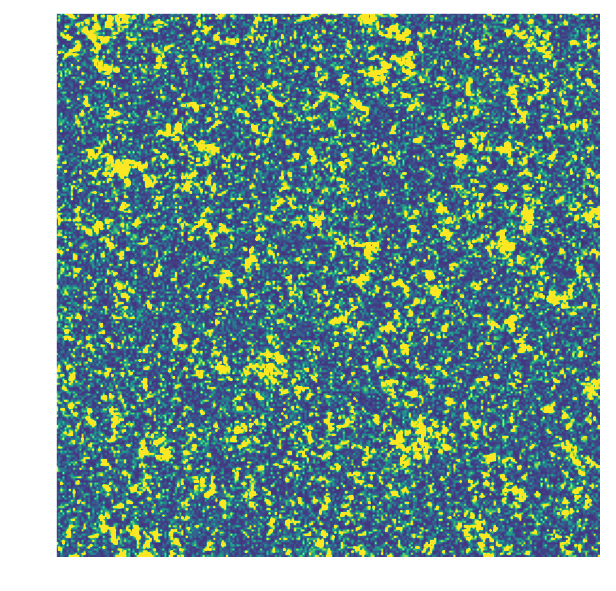

In [88]:
fig,(ax1) = plt.subplots(1,1)

mean,std=np.mean(delta_g2),np.std(delta_g2)

ax1.imshow(delta_g2[0],vmin=mean-std,vmax=mean+std)

In [83]:

BoxSize            =2*np.pi/params.kmin #Mpc/h
#seed              = 1      #value of the initial random seed
threads           = 1      #number of openmp threads
verbose           = True   #whether to print some information
axis=0
MAS='None'



Computing power spectrum of the field...
Time to complete loop = 0.92
Time taken = 1.32 seconds

Computing power spectrum of the field...
Time to complete loop = 0.78
Time taken = 1.26 seconds

Computing power spectrum of the field...
Time to complete loop = 1.08
Time taken = 1.55 seconds


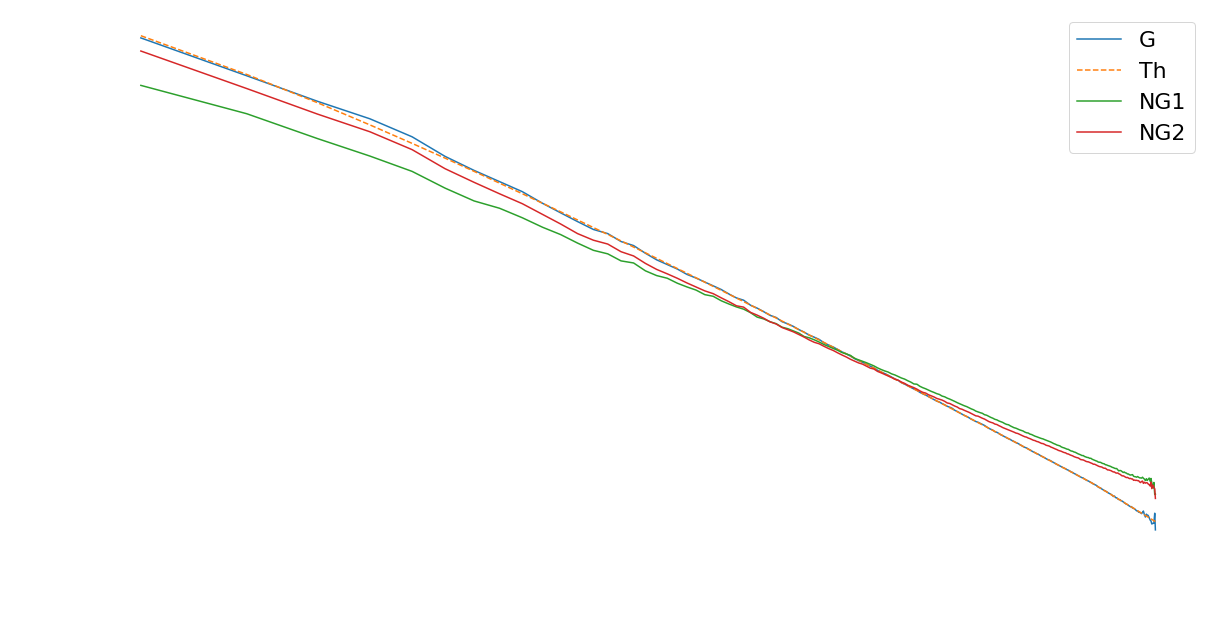

In [84]:


Pk = PKL.Pk(np.float32(delta_g), BoxSize, axis, MAS, threads, verbose)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0]

plt.loglog(k,Pk0, label='G') 

plt.loglog(k,primordial(k)*np.interp(k,transfer['k'],transfer['d_m'])**2,'--',label='Th') 


Pk = PKL.Pk(np.float32(delta_ng1), BoxSize, axis, MAS, threads, verbose)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0]

plt.loglog(k,Pk0, label='NG1') 

Pk = PKL.Pk(np.float32(delta_ng2), BoxSize, axis, MAS, threads, verbose)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0]

plt.loglog(k,Pk0, label='NG2') 



# cdm=np.loadtxt('../build/_deps/input_class_parameters00_z1_pk_CDM.dat')
# plt.loglog(cdm[:,0],cdm[:,1], '--', label='TH cdm') 
plt.xlabel('k')
plt.ylabel('Pk')
plt.legend()

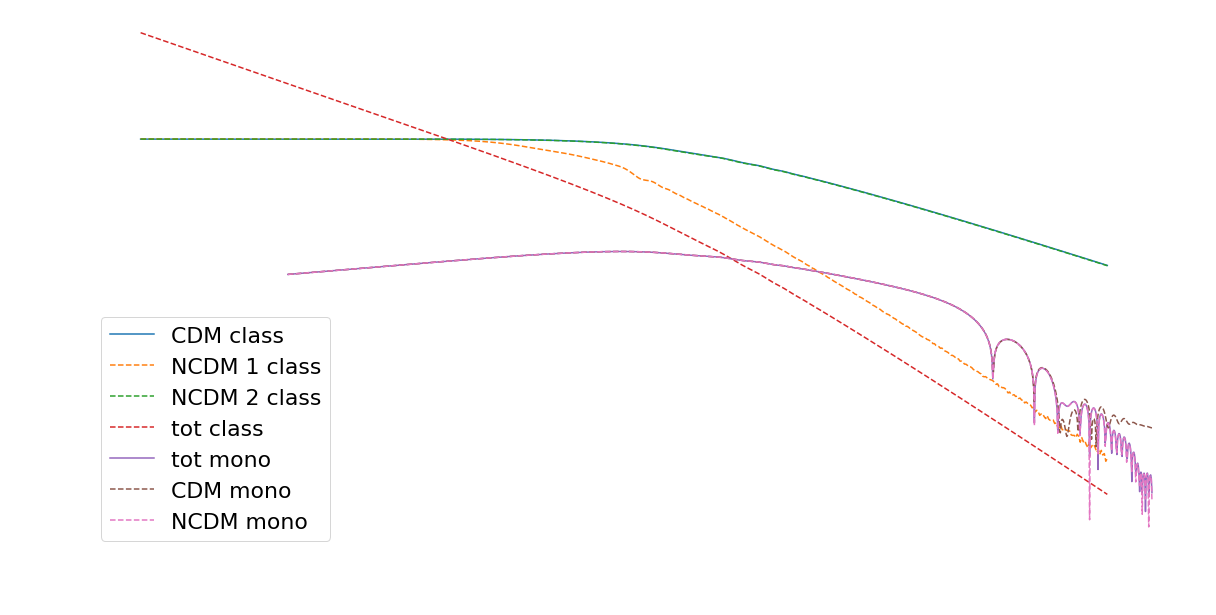

In [71]:
#plt.plot(transfer['k'],transfer['d_cdm'],label='T_cdm')

tr=np.loadtxt('/home/thomas/monofonic/build/_deps/input_class_parameters00_z1_tk.dat')
tr2=np.loadtxt('/home/thomas/monofonic/build/input_transfer.txt')

plt.plot(tr[:,0],np.abs(tr[:,3])/tr[:,0]**2*params.h**2,'-',label='CDM class')
plt.plot(tr[:,0],np.abs(tr[:,5])/tr[:,0]**2*params.h**2,'--',label='NCDM 1 class')
plt.plot(tr[:,0],np.abs(tr[:,6])/tr[:,0]**2*params.h**2,'--',label='NCDM 2 class')
plt.plot(tr[:,0],np.abs(tr[:,7])/tr[:,0]**2*params.h**2,'--',label='tot class')

#plt.plot(tr2[:,0],np.abs(tr2[:,5]), label='NCDM mono')
plt.plot(tr2[:,0],np.abs(tr2[:,3]), label='tot mono')
plt.plot(tr2[:,0],np.abs(tr2[:,1]), '--' , label='CDM mono')
plt.plot(tr2[:,0],np.abs(tr2[:,2]), '--' , label='NCDM mono')

#plt.plot(transfer['k'],np.abs(transfer['d_ncdm[0]']),'--',label='T_ncdm')
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='b')
plt.legend()
plt.xlabel('k')
plt.ylabel('T(k)')
plt.xscale('log')
plt.yscale('log')

In [5]:


Fdelta1 = zeta2fields('d_ncdm[0]',zeta,k_grid_lin,transfer)
Fv1 = zeta2fields('v_ncdm[0]',zeta,k_grid_lin,transfer)
Fphi1 = zeta2fields('v_ncdm[0]',zeta,k_grid_lin,transfer)

delta1=ifft(Fdelta1)
v1=ifft(Fv1)
phi1=ifft(Fphi1)

save_h5(params.output_path+'delta1.h5',delta1)
save_h5(params.output_path+'v1.h5',v1)
save_h5(params.output_path+'phi1.h5',phi1)

N has to be odd to include 0: N+=1


/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


OSError: Unable to create file (unable to open file: name = '/home/thomas/song/wdm/delta1.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
# calcul de delta(2)

std=np.std(delta1)

delta2_1= (delta1 + params.F*(delta1**2*std**(-1/2)-std**(1/2)))/(1+2*params.F**2)**(1/2)
delta_tot_2= (delta1 + params.F*delta1**3 /std**2)/np.sqrt(1+6*params.F+15*params.F**2)

Spectre de puissance primordial $P_{\zeta}(k) = \frac{2\pi^2A_s}{k^3} \left(\frac{k}{k_0}\right)^{n_s-1}$

Spectre de puissance du contrast de densité $P_{\delta} = T_{\delta}(k)^2 P_{\zeta}(k)$


$\left< \delta(\mathbf k_1) \delta(\mathbf k_2) \right> = (2\pi)^3 \delta(\mathbf k_1+ \mathbf k_2) P(k_2)$
 
$P(k_2)= \int d^3 r ~ \xi_2(r) e^{ - i \mathbf k_2 \mathbf r}$


$\Delta \phi(x) = \delta(x)$ 

$-k^2 \phi(k) = \delta(k)$

$ \phi(k) = -\delta(k) /k^2$

$\phi(\mathbf {x}) = \mathcal F^{-1}_x \left[ -\frac{\delta(\mathbf {k})}{k^2} \right]$ 

In [56]:
cd /home/thomas/class_public/output

/home/thomas/class_public/output


(0.0001, 1)

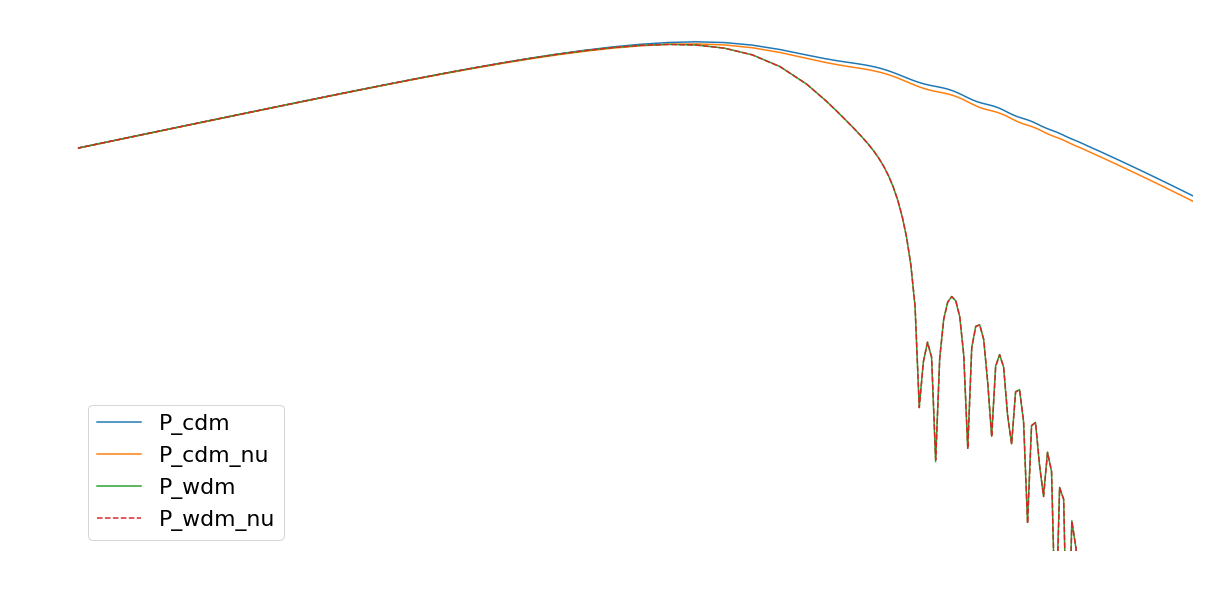

In [73]:
Pk_cdm = np.loadtxt('myclass_00_pk.dat')
Pk_cdm_nu = np.loadtxt('myclass_01_pk.dat')
Pk_wdm = np.loadtxt('myclass_05_pk.dat')
Pk_wdm_nu = np.loadtxt('myclass_06_pk.dat')

plt.plot(Pk_cdm[:,0],Pk_cdm[:,1],label='P_cdm')
plt.plot(Pk_cdm_nu[:,0],Pk_cdm_nu[:,1],label='P_cdm_nu')
plt.plot(Pk_wdm[:,0],Pk_wdm[:,1],label='P_wdm')
plt.plot(Pk_wdm_nu[:,0],Pk_wdm_nu[:,1],'--',label='P_wdm_nu')

plt.legend()
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xscale('log)
plt.yscale('log')
plt.ylim(1,10**9)
plt.xlim(10**-4,1)